In [1]:
#from PIL import Image

In [2]:
#im = Image.open('C:/Users/lg/Desktop/cnn.jpg')

In [3]:
#im.save('rename.jpg')
#im.show()

In [4]:
import matplotlib.pyplot as plt

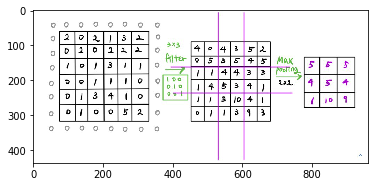

In [5]:
a = plt.imread('./cnn.jpg')
plt.imshow(a)

In [6]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init
import torch.nn as nn

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# for reproducibility
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [8]:
# parameters
learning_rate = 0.001
training_epochs = 15
batch_size = 100

In [9]:
#MNIST dataset
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

In [10]:
# dataset loader
data_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

In [11]:
class CNN(torch.nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        self.keep_prob = 0.5
        
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size = 4, stride = 1, padding = 1),
            # ? x 32 x 27 x 27
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size = 2, stride = 2))
            # ? x 32 x 13 x 13
        
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1),
            # ? x 64 x 13 x 13
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size = 2, stride = 2))
            # ? x 64 x 6 x 6
        
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size = 3, stride = 2, padding = 1),
            # ? x 128 x 3 x 3
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 1))
            # ? x 128 x 2 x 2
        
        self.fc1 = torch.nn.Linear(128 * 2 * 2, 625, bias = True)
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        self.layer4 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(p = 1 - self.keep_prob))
        
        self.fc2 = torch.nn.Linear(625, 10, bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0),-1)
        out = self.layer4(out)
        out = self.fc2(out)
        return out

In [12]:
model = CNN().to(device)
criterion = nn.CrossEntropyLoss().to(device)    # Softmax is internally computed.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [13]:
# train my model
total_batch = len(data_loader)
model.train()    # set the model to train mode (dropout=True)

for epoch in range(training_epochs):
    avg_cost = 0

    for X, Y in data_loader:
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = model(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))


[Epoch:    1] cost = 0.260818541
[Epoch:    2] cost = 0.0653349981
[Epoch:    3] cost = 0.0462695546
[Epoch:    4] cost = 0.0356797874
[Epoch:    5] cost = 0.0290069245
[Epoch:    6] cost = 0.0246454626
[Epoch:    7] cost = 0.0211415365
[Epoch:    8] cost = 0.0169709064
[Epoch:    9] cost = 0.0155284861
[Epoch:   10] cost = 0.0168496426
[Epoch:   11] cost = 0.0121403234
[Epoch:   12] cost = 0.0110005122
[Epoch:   13] cost = 0.0121472739
[Epoch:   14] cost = 0.00828384608
[Epoch:   15] cost = 0.00880440697


In [14]:
# Test model and check accuracy
with torch.no_grad():
    model.eval()    # set the model to evaluation mode (dropout=False)

    X_test = mnist_test.test_data.view(len(mnist_test), 1, 28, 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

C:\Users\lg\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
C:\Users\lg\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Accuracy: 0.9876999855041504
